# Bulge fraction

In [1]:
# Imports
import astropy.constants as c
import astropy.units as u
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
%matplotlib inline
matplotlib.rc('font',size=20)

In [41]:
# Parameters

# Simulation data
#outputDir='../../../output/Hen15/'
outputDir='../../../output/merge/hack1/'
obsDir='../../../../Obsdata/'
filePrefix='SA_output_'
filePostfix='.h5'
snap='58'
redshift=0. # Read from file
firstFile=0
lastFile=9
maxFile=512

# Observational data
#Loading the 3 different bulge fractions obs files
obsdir='../../../../Obsdata/'
obsBulgeFile='conselice2006_bulge_fract.txt'
obsDiskFile='conselice2006_disk_fract.txt'
obsIrrFile='conselice2006_irr_fract.txt'
obsHubble=0.70

# Divisions between bulge classes
logRatio1=-0.154902
logRatio2=-2

# Bins for hostogram and plotting
binwidth=0.25
xrange=np.array([8.8,11.5])
bins=np.arange(xrange[0],xrange[1]+0.001,binwidth)

# Simulation parameters (read from file!)
hubble=0.673
boxside=480.28  # Units Mpc/h 

In [42]:
# First determine the size of the arrays that we need to hold the data
nGal=0
for iFile in range(firstFile,lastFile+1):
    # The following line closes the file at the end of the loop
    with h5py.File(outputDir+filePrefix+'%i'%iFile+filePostfix,'r') as f:
        nGal+=len(f[snap])
print('nGal=',nGal)

# Declare numpy arrays to hold the data
Type=np.empty(nGal)
BulgeMass=np.empty(nGal)
DiskMass=np.empty(nGal)
StellarMass=np.empty(nGal)

# Now read in the data
iGal=0
for iFile in range(firstFile,lastFile+1):
    # The following line closes the file at the end of the loop
    with h5py.File(outputDir+filePrefix+'%i'%iFile+filePostfix,'r') as f:
        nGalFile=len(f[snap])
        Type[iGal:iGal+nGalFile]=f[snap]['Type']
        BulgeMass[iGal:iGal+nGalFile]=f[snap]['BulgeMass']
        DiskMass[iGal:iGal+nGalFile]=f[snap]['DiskMass']
        StellarMass[iGal:iGal+nGalFile]=f[snap]['StellarMass']
        iGal+=nGalFile
assert np.all(abs(StellarMass-BulgeMass-DiskMass)<1e-5*StellarMass)

# Put into observer units and add scatter to stellar mass estimate
offset=10+np.log10(hubble)
logBulge=np.log10(BulgeMass)+offset
logDisk=np.log10(DiskMass)+offset
logStellarMass=np.log10(StellarMass)+offset
logStellarMassObs=logStellarMass+np.random.randn(nGal)*0.08*(1+redshift)

nGal= 80404


//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in log10


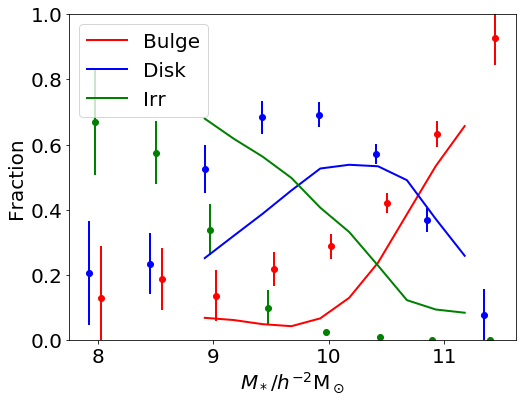

In [43]:
# Put galaxies into bins
indBin=np.digitize(logStellarMassObs,bins)
nBin=len(bins)-1
x=np.empty(nBin)
yBulge=np.empty(nBin)
yDisk=np.empty(nBin)

yIrr=np.empty(nBin)
# Loop over bins, couting fractions in each class
for iBin in range(nBin):
    x[iBin]=0.5*(bins[iBin]+bins[iBin+1])
    indThisBin=np.where(indBin==iBin+1)[0]
    allBin=len(indThisBin)
    # Bulges
    yBulge[iBin]=len(np.where((logBulge[indThisBin]-logStellarMass[indThisBin])>logRatio1)[0])/allBin
    # Disks
    yIrr[iBin]=len(np.where((logBulge[indThisBin]-logStellarMass[indThisBin])<logRatio2)[0])/allBin
    # Intermediates
    yDisk[iBin]=1.-yBulge[iBin]-yIrr[iBin]
# Plot
plt.figure(figsize=[8,6])
plt.xlabel(r'$M_*/h^{-2}\mathrm{M}_\odot$')
plt.ylabel(r'Fraction')
plt.ylim([0,1])
plt.plot(x,yBulge,'r-',label='Bulge')
plt.plot(x,yDisk,'b-',label='Disk')
plt.plot(x,yIrr,'g-',label='Irr')
plt.legend()
# Plot observations
plt.gca().set_prop_cycle(None) # Doesn't make errorbar use the correct colours
obsBulge=np.loadtxt(obsdir+obsBulgeFile)
obsMass=obsBulge[:,0]+2*np.log10(obsHubble)
plt.errorbar(obsMass,obsBulge[:,1],yerr=obsBulge[:,2],marker='o',linestyle='None',color='r')
obsDisk=np.loadtxt(obsdir+obsDiskFile)
obsMass=obsDisk[:,0]+2*np.log10(obsHubble)
plt.errorbar(obsMass,obsDisk[:,1],yerr=obsDisk[:,2],marker='o',linestyle='None',color='b')
obsIrr=np.loadtxt(obsdir+obsIrrFile)
obsMass=obsIrr[:,0]+2*np.log10(obsHubble)
plt.errorbar(obsMass,obsIrr[:,1],yerr=obsIrr[:,2],marker='o',linestyle='None',color='g')
plt.savefig('figs/BulgeFraction_'+outputDir.split('/')[-2]+'.png')